In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from pathlib import Path
from MITRotor import IEA15MW

In [2]:
rotor = IEA15MW()

nElements = 32
nSections = 191

In [3]:
def extract_columns(file_list):
    data_dict = {}
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            
            # Use the filename without the path and extension as the dictionary key
            key = Path(file).parent.name
            data_dict[key] = data
    
    return data_dict

In [4]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/15MW/gad_sweep/*/input_sounding")

data = extract_columns(file_list)

t = np.linspace(0,2*np.pi,nSections)
r = np.linspace(0,1,nElements)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * rotor.R + 378

In [5]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [ ]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']

wrfles_bem = []
for count, name in enumerate(casenames):
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/15MW/gad_sweep/'+casenames[count]+'_new.npz')))


/tmp/ipykernel_487692/3775070615.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)
/tmp/ipykernel_487692/3775070615.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)
/tmp/ipykernel_487692/3775070615.py:80: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)


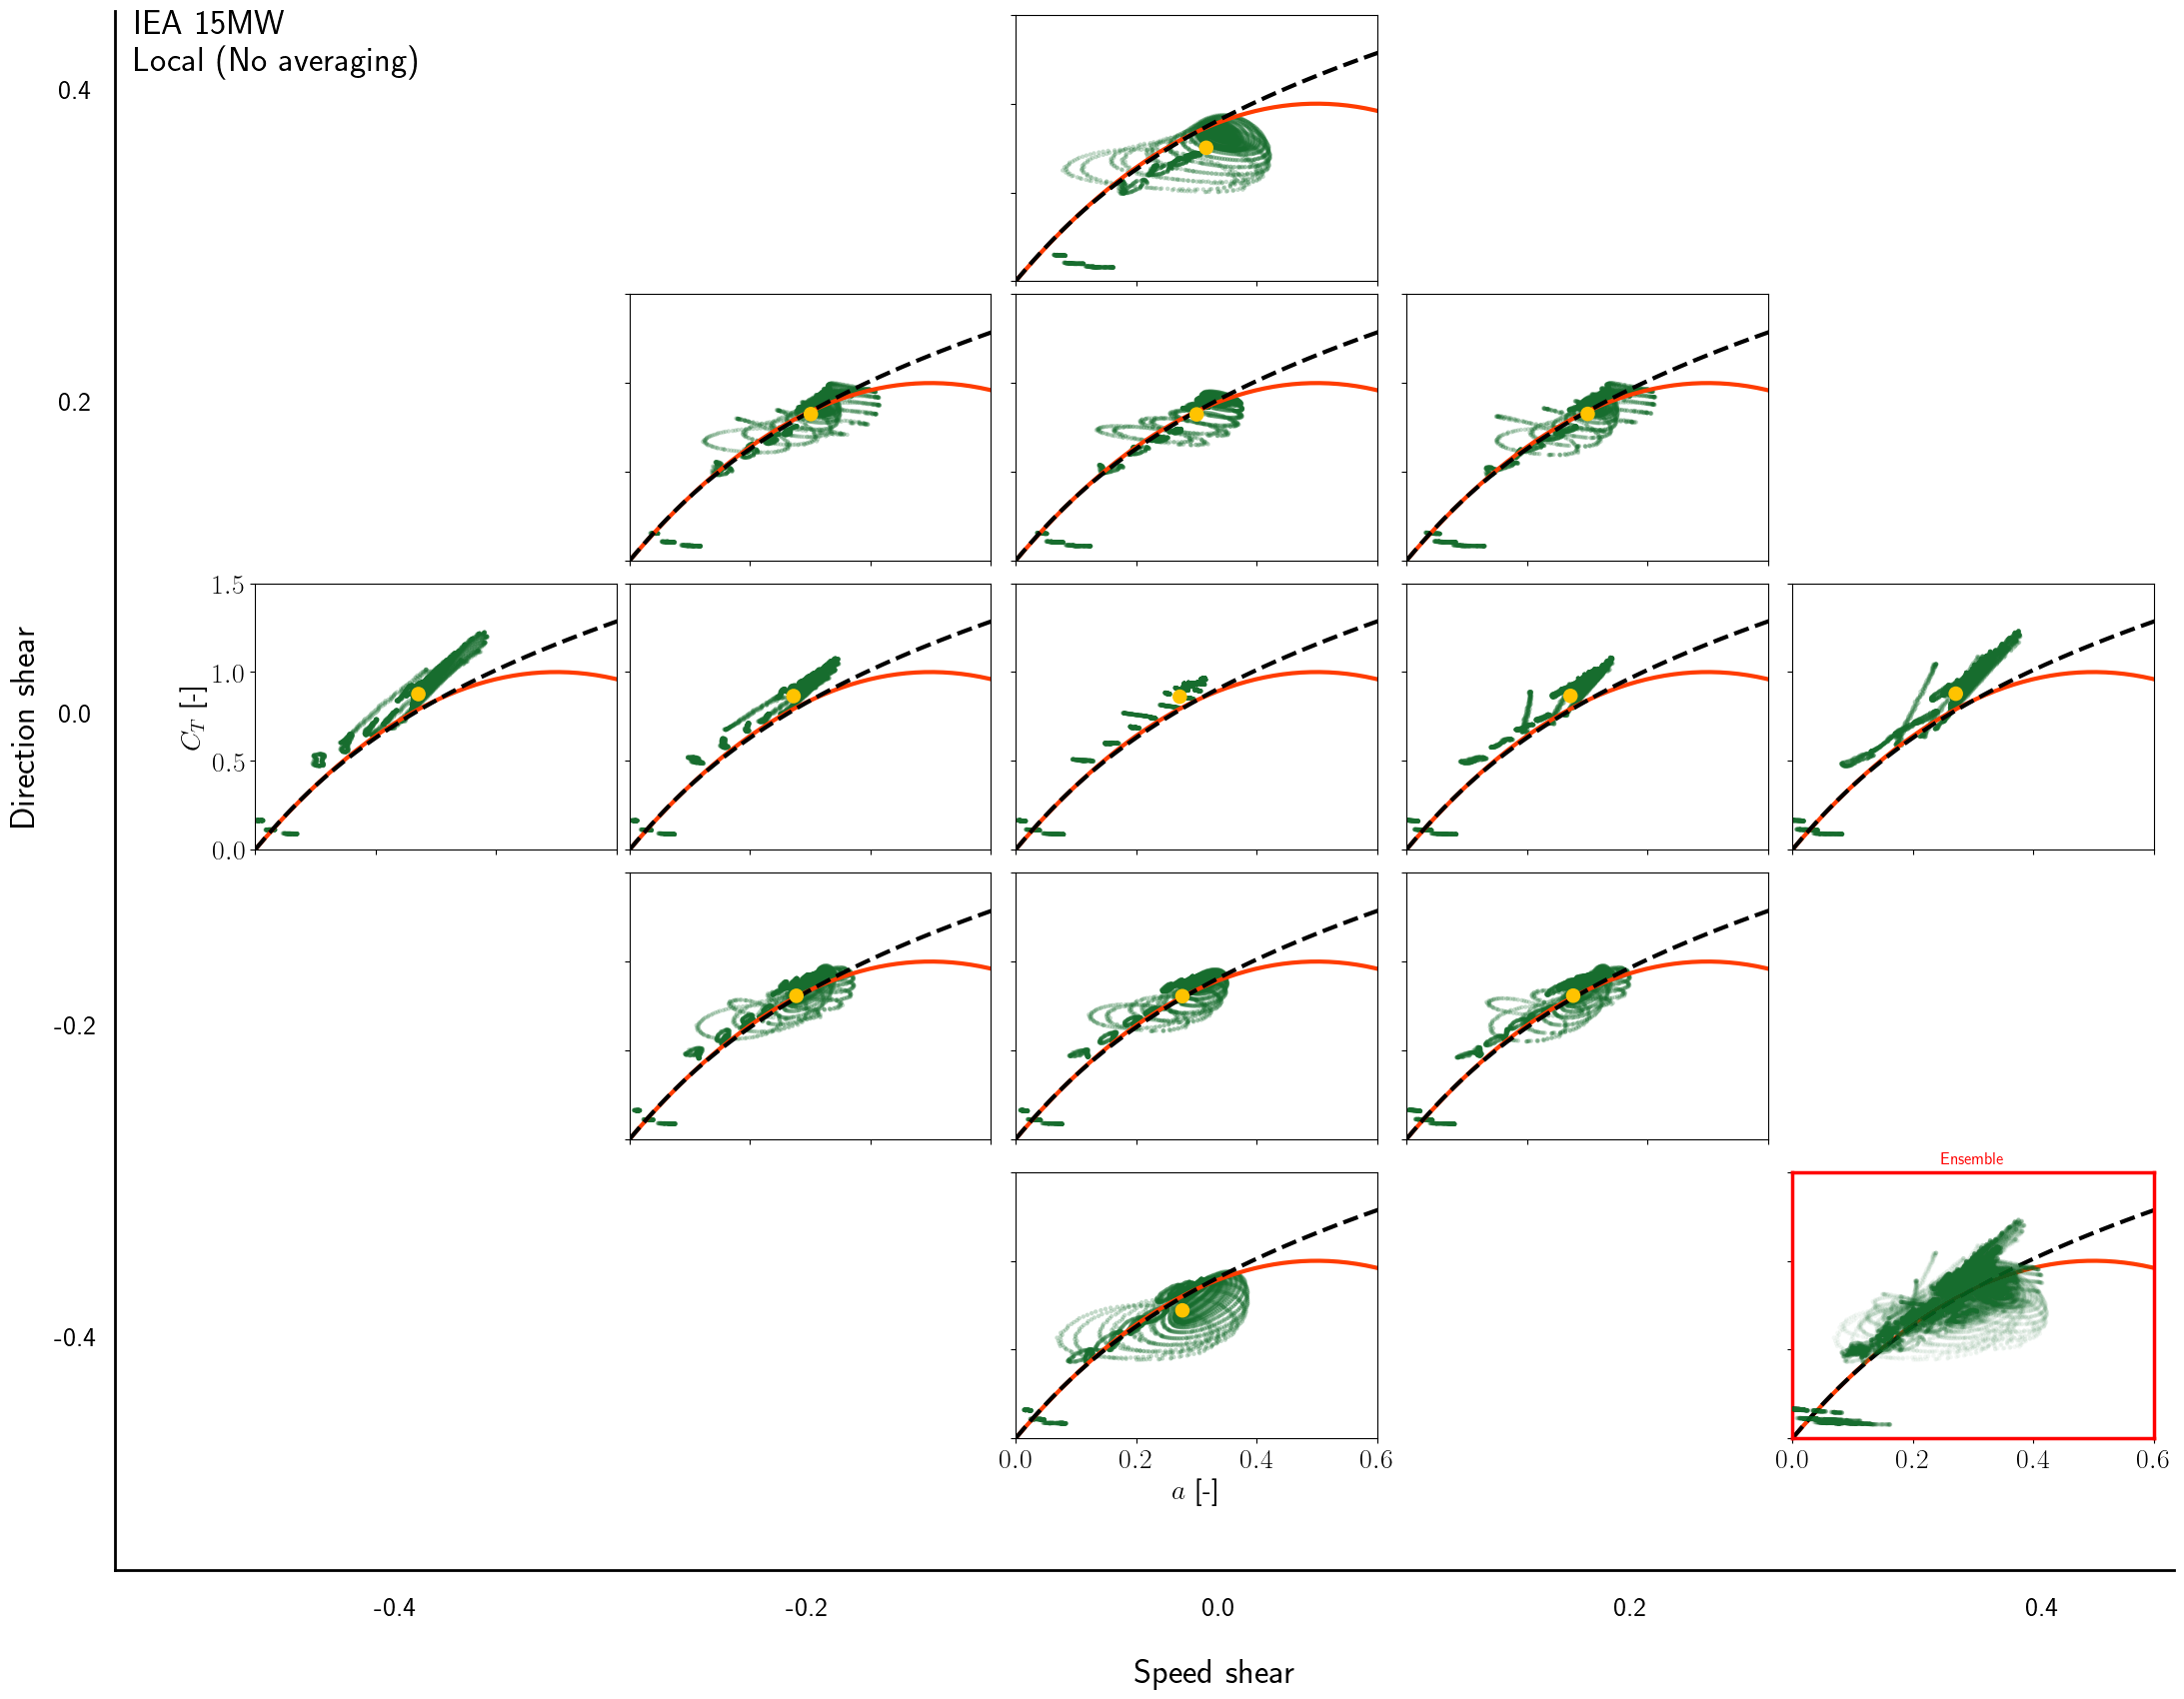

In [ ]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

ind = np.zeros((nElements, nSections, len(xs)))
ct  = np.zeros((nElements, nSections, len(xs)))

for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    # Compute induction
    ind[:,:,count] = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T

    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    sigma = rotor.solidity_func(r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / ((u_inf**2 + v_inf**2)**(1/2)).T

    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    ct[:,:,count] = sigma * W**2 * Cax

    mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)

    ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct[:,:,count], np.linspace(0, 2*np.pi, nSections), axis=-1)
    ind_annular = 1/(2 * np.pi) * np.trapezoid(ind[:,:,count], np.linspace(0, 2*np.pi, nSections), axis=-1)

    ct_rotor = 2 * np.trapezoid(ct_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    ind_rotor = 2 * np.trapezoid(ind_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)

    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=2)

    ct_mad = np.linspace(0,1.75,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=3)

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)

line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)
fig.text(-0.02,0.985, 'IEA 15MW', ha='left', fontsize=25,rotation=0)
fig.text(-0.02,0.96, 'Local (No averaging)', ha='left', fontsize=25,rotation=0)

plt.savefig(f"./figs/wrf_15MW_local.png", bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
# Define the specific equation (e.g., linear: y = a * x + b)
def madsen_func(CT, a, b, c):

    # k1 = 0.0883
    # k2 = 0.0586
    # k3 = 0.2460

    return a * CT**3 + b * CT**2 + c * CT

In [ ]:
# V4

v4 = [0,12]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v4].flatten()
ct_mom = ct[:,:,v4].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f},")

# Generate fitted values
x_fit_v4 = np.linspace(0, 0.6, 100)
y_fit_v4 = madsen_func(x_fit_v4, a_fit, b_fit, c_fit)

Fitted parameters: a = -1.596, b = -4.009, c = 5.605,


In [ ]:
# V2

v2 = [1, 2, 3, 9, 10, 11]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v2].flatten()
ct_mom = ct[:,:,v2].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f},")

# Generate fitted values
x_fit_v2 = np.linspace(0, 0.6, 100)
y_fit_v2 = madsen_func(x_fit_v2, a_fit, b_fit, c_fit)

Fitted parameters: a = 4.376, b = -12.350, c = 7.973,


In [ ]:
# V0

v0 = [4, 5, 6, 7, 8]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v0].flatten()
ct_mom = ct[:,:,v0].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f},")

# Generate fitted values
x_fit_v0 = np.linspace(0, 0.6, 100)
y_fit_v0 = madsen_func(x_fit_v0, a_fit, b_fit, c_fit)

Fitted parameters: a = 7.704, b = -17.046, c = 9.340,


/tmp/ipykernel_3208341/1697300011.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[0].scatter(ind[:,:,v4[i]], ct[:,:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.05)
/tmp/ipykernel_3208341/1697300011.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[1].scatter(ind[:,:,v2[i]], ct[:,:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.05)
/tmp/ipykernel_3208341/1697300011.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[2].scatter(ind[:,:,v0[i]], ct[:,:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.05)


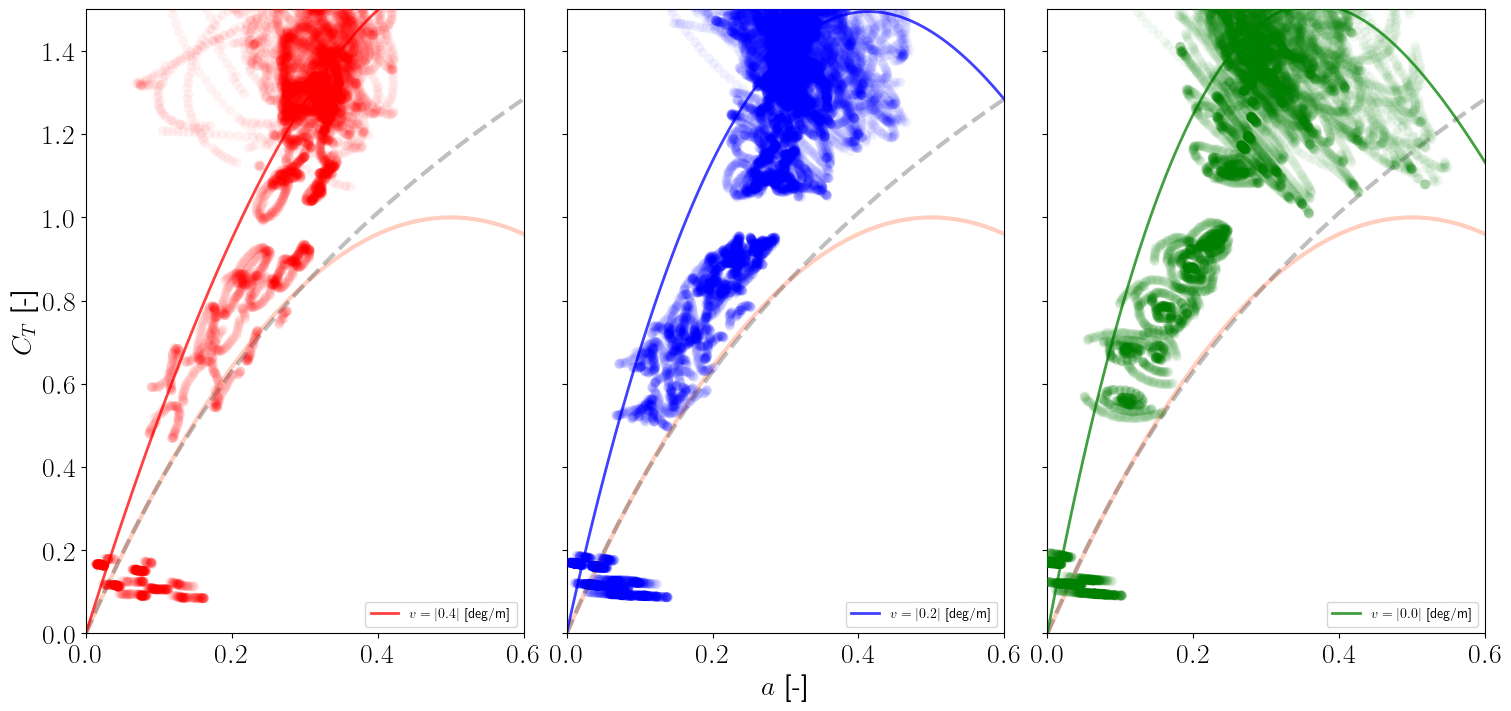

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15, 7), constrained_layout=True,sharex=True, sharey=True)

a_mom  = np.linspace(0,0.75,50)
ct_mom = 4 * a_mom * (1 - a_mom)

ct_mad = np.linspace(0,1.5,75)
k1 = 0.2460
k2 = 0.0586
k3 = 0.0883
a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad

for i in range(3):
    ax[i].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1,alpha=0.25)

    ax[i].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2,alpha=0.25)

    ax[i].set_xlim([0,0.6])
    ax[i].set_ylim([0,1.5])

ax[0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[1].set_xlabel('$a$ [-]', fontsize=20)

ax[2].plot(x_fit_v0, y_fit_v0, 'g-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.0|$ [deg/m]')
ax[1].plot(x_fit_v2, y_fit_v2, 'b-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.2|$ [deg/m]')
ax[0].plot(x_fit_v4, y_fit_v4, 'r-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.4|$ [deg/m]')

v4 = [0,12]
v2 = [1, 2, 3, 9, 10, 11]
v0 = [4, 5, 6, 7, 8]

for i in range(len(v4)):
    mesh = ax[0].scatter(ind[:,:,v4[i]], ct[:,:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.05)

for i in range(len(v2)):
    mesh = ax[1].scatter(ind[:,:,v2[i]], ct[:,:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.05)

for i in range(len(v0)):
    mesh = ax[2].scatter(ind[:,:,v0[i]], ct[:,:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.05)

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [ ]:
# Define the specific equation (e.g., linear: y = a * x + b)
def madsen_func(CT, a, b, c, d):

    # k1 = 0.0883
    # k2 = 0.0586
    # k3 = 0.2460

    return a * CT**3 + b * CT**2 + c * CT + d

In [ ]:
# V4

v4 = [0,12]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v4].flatten()
ct_mom = ct[:,:,v4].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit, d_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f}, d = {d_fit:.3f}")

# Generate fitted values
x_fit_v4 = np.linspace(0, 0.6, 100)
y_fit_v4 = madsen_func(x_fit_v4, a_fit, b_fit, c_fit, d_fit)

Fitted parameters: a = 1.647, b = -8.840, c = 7.364, d = -0.171


In [ ]:
# V2

v2 = [1, 2, 3, 9, 10, 11]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v2].flatten()
ct_mom = ct[:,:,v2].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit, d_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f}, d = {d_fit:.3f}")

# Generate fitted values
x_fit_v2 = np.linspace(0, 0.6, 100)
y_fit_v2 = madsen_func(x_fit_v2, a_fit, b_fit, c_fit, d_fit)

Fitted parameters: a = 6.002, b = -14.783, c = 8.871, d = -0.090


In [ ]:
# V0

v0 = [4, 5, 6, 7, 8]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind[:,:,v0].flatten()
ct_mom = ct[:,:,v0].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit, b_fit, c_fit, d_fit = params
print(f"Fitted parameters: a = {a_fit:.3f}, b = {b_fit:.3f}, c = {c_fit:.3f}, d = {d_fit:.3f}")

# Generate fitted values
x_fit_v0 = np.linspace(0, 0.6, 100)
y_fit_v0 = madsen_func(x_fit_v0, a_fit, b_fit, c_fit, d_fit)

Fitted parameters: a = -0.080, b = -4.824, c = 4.315, d = 0.586


/tmp/ipykernel_3208341/1697300011.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[0].scatter(ind[:,:,v4[i]], ct[:,:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.05)
/tmp/ipykernel_3208341/1697300011.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[1].scatter(ind[:,:,v2[i]], ct[:,:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.05)
/tmp/ipykernel_3208341/1697300011.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[2].scatter(ind[:,:,v0[i]], ct[:,:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.05)


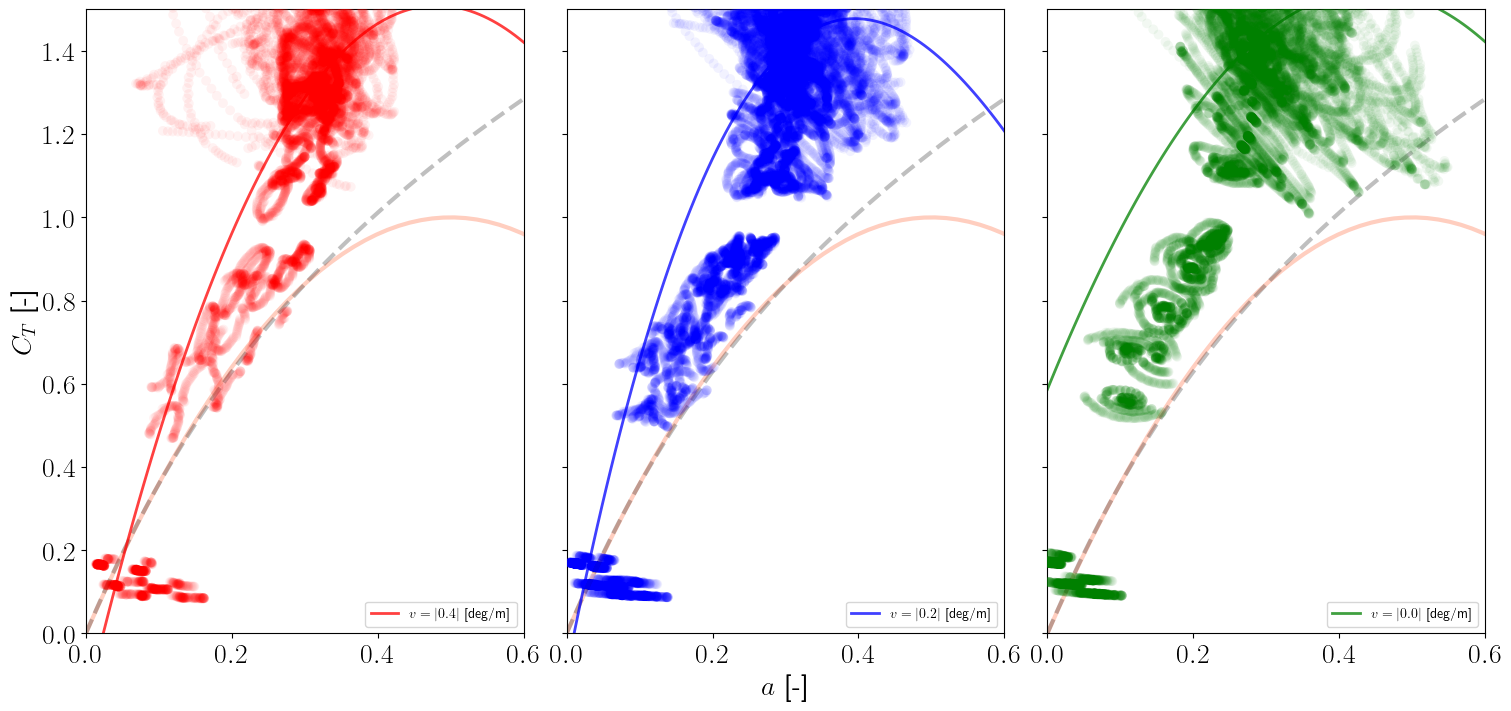

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15, 7), constrained_layout=True,sharex=True, sharey=True)

a_mom  = np.linspace(0,0.75,50)
ct_mom = 4 * a_mom * (1 - a_mom)

ct_mad = np.linspace(0,1.5,75)
k1 = 0.2460
k2 = 0.0586
k3 = 0.0883
a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad

for i in range(3):
    ax[i].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1,alpha=0.25)

    ax[i].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2,alpha=0.25)

    ax[i].set_xlim([0,0.6])
    ax[i].set_ylim([0,1.5])

ax[0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[1].set_xlabel('$a$ [-]', fontsize=20)

ax[2].plot(x_fit_v0, y_fit_v0, 'g-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.0|$ [deg/m]')
ax[1].plot(x_fit_v2, y_fit_v2, 'b-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.2|$ [deg/m]')
ax[0].plot(x_fit_v4, y_fit_v4, 'r-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.4|$ [deg/m]')

v4 = [0,12]
v2 = [1, 2, 3, 9, 10, 11]
v0 = [4, 5, 6, 7, 8]

for i in range(len(v4)):
    mesh = ax[0].scatter(ind[:,:,v4[i]], ct[:,:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.05)

for i in range(len(v2)):
    mesh = ax[1].scatter(ind[:,:,v2[i]], ct[:,:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.05)

for i in range(len(v0)):
    mesh = ax[2].scatter(ind[:,:,v0[i]], ct[:,:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.05)

ax[0].legend()
ax[1].legend()
ax[2].legend()

## NN Proof of concept

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

v1 = 4 * np.ones_like(ind[:,:,0])
s1 = 0 * np.ones_like(ind[:,:,0])

In [ ]:
N, M = ind[:,:,0].shape  # Grid dimensions

In [ ]:
# Create input-output pairs
r_flat     = R.T.flatten()
theta_flat = T.T.flatten()
x_flat     = ind[:,:,0].flatten()
y_flat     = ct[:,:,0].flatten()
v1_flat    = v1.flatten()  # Assuming z1 is a 2D matrix
s1_flat    = s1.flatten()  # Assuming z2 is a 2D matrix


In [ ]:
data = np.column_stack([r_flat, theta_flat, v1_flat, s1_flat, x_flat, y_flat])


In [ ]:
np.random.shuffle(data)

In [ ]:
split_idx = int(0.8 * data.shape[0])
train_data, val_data = data[:split_idx], data[split_idx:]

In [ ]:
X_train, Y_train = train_data[:, :4], train_data[:, 4:]
X_val, Y_val = val_data[:, :4], val_data[:, 4:]

In [ ]:
# Define the feed-forward neural network
class PolarToCartesianNN(nn.Module):
    def __init__(self):
        super(PolarToCartesianNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),  # Now takes 4 inputs (r, θ, z1, z2)
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer (x, y)
        )
    
    def forward(self, inputs):
        return self.model(inputs)

In [ ]:
model = PolarToCartesianNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

In [ ]:
# Create DataLoader for batch training
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
batch_size = 32  # Adjust as needed
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# Train the model
train_model(model, train_loader, val_loader, epochs=100)

Epoch 1/100, Train Loss: 0.276388, Val Loss: 0.199555
Epoch 2/100, Train Loss: 0.159234, Val Loss: 0.128850
Epoch 3/100, Train Loss: 0.083398, Val Loss: 0.075677
Epoch 4/100, Train Loss: 0.052721, Val Loss: 0.044724
Epoch 5/100, Train Loss: 0.039937, Val Loss: 0.043625
Epoch 6/100, Train Loss: 0.034168, Val Loss: 0.027371
Epoch 7/100, Train Loss: 0.026811, Val Loss: 0.022218
Epoch 8/100, Train Loss: 0.023864, Val Loss: 0.032612
Epoch 9/100, Train Loss: 0.023204, Val Loss: 0.016414
Epoch 10/100, Train Loss: 0.021527, Val Loss: 0.017935
Epoch 11/100, Train Loss: 0.020038, Val Loss: 0.020216
Epoch 12/100, Train Loss: 0.018120, Val Loss: 0.018088
Epoch 13/100, Train Loss: 0.017888, Val Loss: 0.015183
Epoch 14/100, Train Loss: 0.015291, Val Loss: 0.020546
Epoch 15/100, Train Loss: 0.018855, Val Loss: 0.023300
Epoch 16/100, Train Loss: 0.018686, Val Loss: 0.018254
Epoch 17/100, Train Loss: 0.016987, Val Loss: 0.021905
Epoch 18/100, Train Loss: 0.019741, Val Loss: 0.014080
Epoch 19/100, Train

In [ ]:
import torch
import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_val_tensor, Y_val_tensor):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        predictions = model(X_val_tensor).numpy()
    
    ground_truth = Y_val_tensor.numpy()

    # # Compute error metrics
    # mse = mean_squared_error(ground_truth, predictions)
    # mae = mean_absolute_error(ground_truth, predictions)
    
    # print(f"Validation MSE: {mse:.6f}")
    # print(f"Validation MAE: {mae:.6f}")

    return predictions, ground_truth

# Get predictions and ground truth
predictions, ground_truth = evaluate_model(model, X_val_tensor, Y_val_tensor)


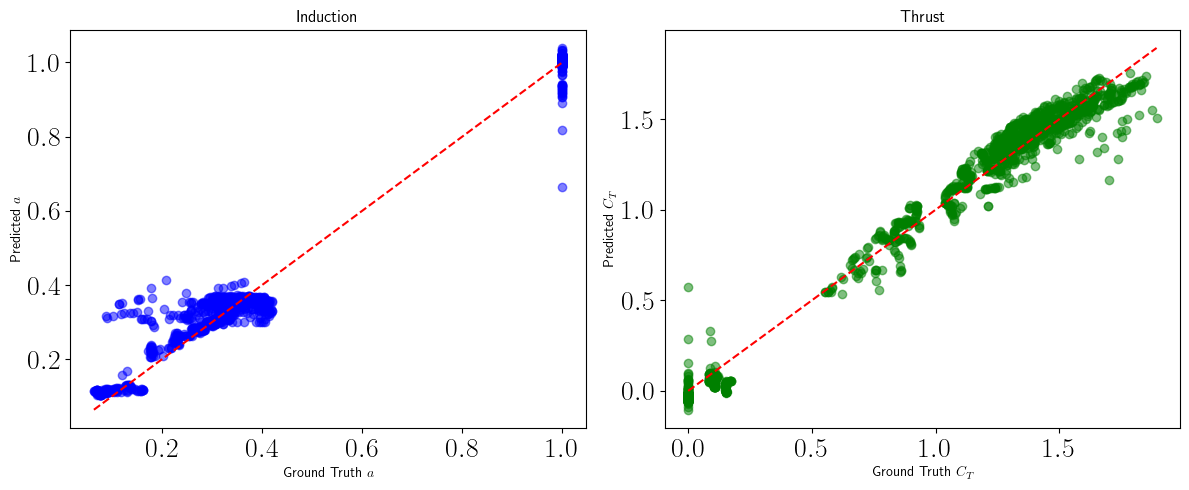

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y from predictions and ground truth
x_pred, y_pred = predictions[:, 0], predictions[:, 1]
x_true, y_true = ground_truth[:, 0], ground_truth[:, 1]

# Scatter plot for x
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_true, x_pred, alpha=0.5, label="Predictions vs Ground Truth", color="blue")
plt.plot([min(x_true), max(x_true)], [min(x_true), max(x_true)], 'r--', label="")
plt.xlabel("Ground Truth $a$")
plt.ylabel("Predicted $a$")
plt.title("Induction")
# plt.legend()
# plt.grid()

# Scatter plot for y
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions vs Ground Truth", color="green")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="")
plt.xlabel("Ground Truth $C_T$")
plt.ylabel("Predicted $C_T$")
plt.title("Thrust")
# plt.legend()
# plt.grid()

plt.tight_layout()
plt.show()


/tmp/ipykernel_3208341/1460609233.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,0], ct[:,:,0], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_3208341/1460609233.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

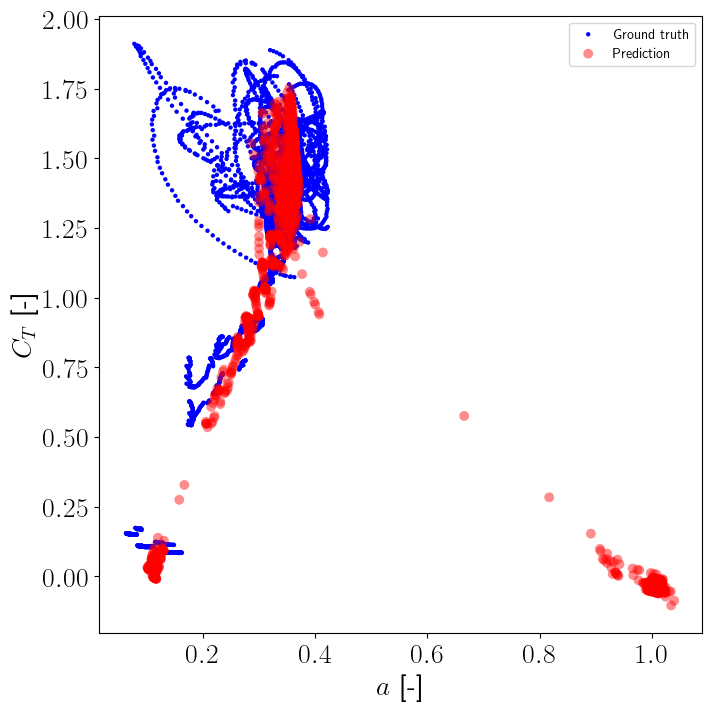

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,0], ct[:,:,0], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

## NN extension to full shear sweep

In [ ]:
v_ref = [4,  2, 2, 2,  0,  0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2,  0,  2,  0]

In [ ]:
# Create input-output pairs
X_train = []
Y_train = []
X_val   = []
Y_val   = []

In [ ]:
for i in range(len(casenames)):

    r_flat     = R.T.flatten()
    theta_flat = T.T.flatten()
    x_flat     = ind[:,:,i].flatten()
    y_flat     = ct[:,:,i].flatten()
    v_flat     = (v_ref[i] * np.ones((26,158))).flatten()
    s_flat     = (s_ref[i] * np.ones((26,158))).flatten()
    
    data = np.column_stack([r_flat, theta_flat, v_flat, s_flat, x_flat, y_flat])
    np.random.shuffle(data)

    split_idx = int(0.8 * data.shape[0])
    train_data, val_data = data[:split_idx], data[split_idx:]

    X_train.append(train_data[:, :4])
    Y_train.append(train_data[:, 4:])
    X_val.append(val_data[:, :4])
    Y_val.append(val_data[:, 4:])


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8288 and the array at index 2 has size 4108

In [ ]:
x_flat

array([0.103549  , 0.10358   , 0.1036146 , ..., 0.20978287, 0.20083966,
       0.19204106], shape=(4108,))

In [ ]:
# Define the feed-forward neural network
class PolarToCartesianNN(nn.Module):
    def __init__(self):
        super(PolarToCartesianNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),  # Now takes 4 inputs (r, θ, z1, z2)
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer (x, y)
        )
    
    def forward(self, inputs):
        return self.model(inputs)

In [ ]:
model = PolarToCartesianNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

In [ ]:
batch_size = 32  # Adjust as needed
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# Train the model
train_model(model, train_loader, val_loader, epochs=100)

Epoch 1/100, Train Loss: 0.049907, Val Loss: 0.049797
Epoch 2/100, Train Loss: 0.049699, Val Loss: 0.049585
Epoch 3/100, Train Loss: 0.049497, Val Loss: 0.049375
Epoch 4/100, Train Loss: 0.049295, Val Loss: 0.049167
Epoch 5/100, Train Loss: 0.049093, Val Loss: 0.048959
Epoch 6/100, Train Loss: 0.048891, Val Loss: 0.048748
Epoch 7/100, Train Loss: 0.048684, Val Loss: 0.048532
Epoch 8/100, Train Loss: 0.048472, Val Loss: 0.048314
Epoch 9/100, Train Loss: 0.048258, Val Loss: 0.048095
Epoch 10/100, Train Loss: 0.048042, Val Loss: 0.047877
Epoch 11/100, Train Loss: 0.047828, Val Loss: 0.047661
Epoch 12/100, Train Loss: 0.047616, Val Loss: 0.047447
Epoch 13/100, Train Loss: 0.047405, Val Loss: 0.047233
Epoch 14/100, Train Loss: 0.047195, Val Loss: 0.047021
Epoch 15/100, Train Loss: 0.046987, Val Loss: 0.046808
Epoch 16/100, Train Loss: 0.046778, Val Loss: 0.046593
Epoch 17/100, Train Loss: 0.046568, Val Loss: 0.046372
Epoch 18/100, Train Loss: 0.046352, Val Loss: 0.046139
Epoch 19/100, Train

In [ ]:
def prepare_evaluation_data(r, theta, z1, z2):
    """Prepare input data using r, theta, and a fixed (z1, z2) pair."""
    r_flat = r.T.flatten()
    theta_flat = theta.T.flatten()
    z1_flat = np.full_like(r_flat, z1)  # Assign given z1 to all points
    z2_flat = np.full_like(r_flat, z2)  # Assign given z2 to all points

    X_eval = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat])
    return X_eval

In [ ]:
v_eval = 4  # Example value
s_eval = 0 # Example value

X_eval = prepare_evaluation_data(R, T, v_eval, s_eval)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

In [ ]:
def predict(model, X_eval_tensor):
    """Run the model on input data to get predicted x, y values."""
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()
    return predictions

predictions = predict(model, X_eval_tensor)
predictions

array([[0.3881319 , 0.72101414],
       [0.38719627, 0.72220886],
       [0.38626072, 0.72340363],
       ...,
       [0.45323804, 1.0014706 ],
       [0.4537738 , 1.0023758 ],
       [0.45430955, 1.0032812 ]], shape=(4108, 2), dtype=float32)

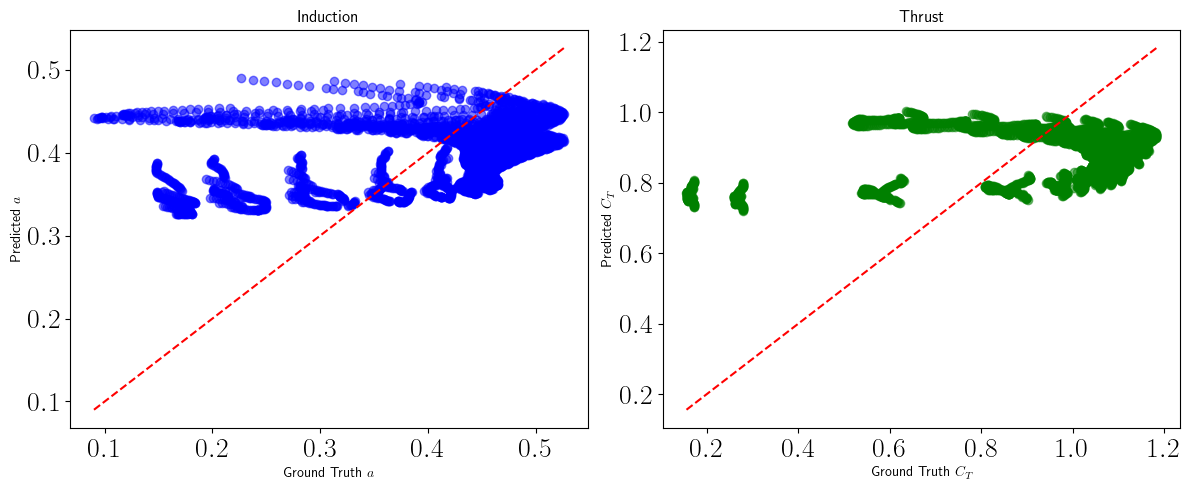

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y from predictions and ground truth
x_pred, y_pred = predictions[:,0], predictions[:,1]
x_true, y_true = ind[:,:,0].flatten(), ct[:,:,1].flatten()

# Scatter plot for x
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_true, x_pred, alpha=0.5, label="Predictions vs Ground Truth", color="blue")
plt.plot([min(x_true), max(x_true)], [min(x_true), max(x_true)], 'r--', label="")
plt.xlabel("Ground Truth $a$")
plt.ylabel("Predicted $a$")
plt.title("Induction")
# plt.legend()
# plt.grid()

# Scatter plot for y
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions vs Ground Truth", color="green")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label="")
plt.xlabel("Ground Truth $C_T$")
plt.ylabel("Predicted $C_T$")
plt.title("Thrust")
# plt.legend()
# plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
def prepare_evaluation_data(r, theta, z1, z2):
    """Prepare input data using r, theta, and a fixed (z1, z2) pair."""
    r_flat = r.flatten()
    theta_flat = theta.flatten()
    z1_flat = np.full_like(r_flat, z1)  # Assign given z1 to all points
    z2_flat = np.full_like(r_flat, z2)  # Assign given z2 to all points

    X_eval = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat])
    return X_eval


In [ ]:
v_eval = 0  # Example value
s_eval = 0  # Example value

X_eval = prepare_evaluation_data(R, T, v_eval, s_eval)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

In [ ]:
def predict(model, X_eval_tensor):
    """Run the model on input data to get predicted x, y values."""
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()
    return predictions

predictions = predict(model, X_eval_tensor)

In [ ]:
x_pred = predictions[:, 0].reshape(r.shape)
y_pred = predictions[:, 1].reshape(r.shape)


In [ ]:
x_true = ind[:,:,0]
x_true = ct[:,:,0]

array([[0.25904279, 0.25915581, 0.25919934, ..., 0.25876775, 0.25887328,
        0.25896523],
       [0.16009296, 0.16040249, 0.16051279, ..., 0.15991497, 0.15994991,
        0.16000953],
       [0.64254288, 0.64163866, 0.64213707, ..., 0.63885057, 0.64038817,
        0.64162267],
       ...,
       [0.70552833, 0.69841434, 0.69595783, ..., 0.71407789, 0.7093859 ,
        0.70525394],
       [0.57744075, 0.57396585, 0.57112068, ..., 0.58993618, 0.58538939,
        0.5812325 ],
       [0.46231049, 0.45927808, 0.45657368, ..., 0.47184412, 0.46854081,
        0.46538128]], shape=(26, 158))

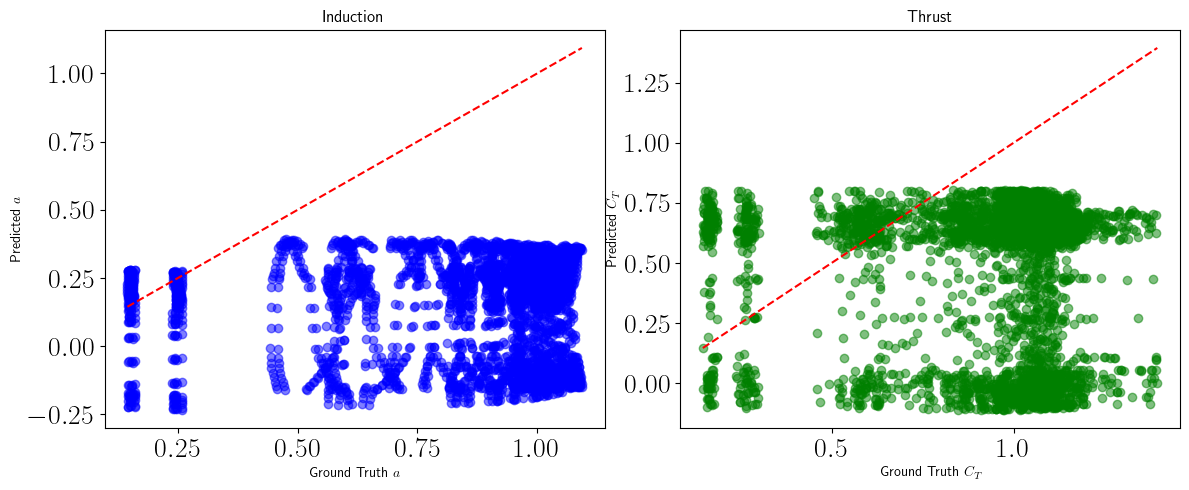

In [ ]:

# Extract x and y from predictions and ground truth

# Scatter plot for x
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_true.flatten(), x_pred.flatten(), alpha=0.5, label="Predictions vs Ground Truth", color="blue")
plt.plot([min(x_true.flatten()), max(x_true.flatten())], [min(x_true.flatten()), max(x_true.flatten())], 'r--', label="")
plt.xlabel("Ground Truth $a$")
plt.ylabel("Predicted $a$")
plt.title("Induction")
# plt.legend()
# plt.grid()

# Scatter plot for y
plt.subplot(1, 2, 2)
plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, label="Predictions vs Ground Truth", color="green")
plt.plot([min(y_true.flatten()), max(y_true.flatten())], [min(y_true.flatten()), max(y_true.flatten())], 'r--', label="")
plt.xlabel("Ground Truth $C_T$")
plt.ylabel("Predicted $C_T$")
plt.title("Thrust")
# plt.legend()
# plt.grid()

plt.tight_layout()
plt.show()

/tmp/ipykernel_298185/1460609233.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,0], ct[:,:,0], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_298185/1460609233.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

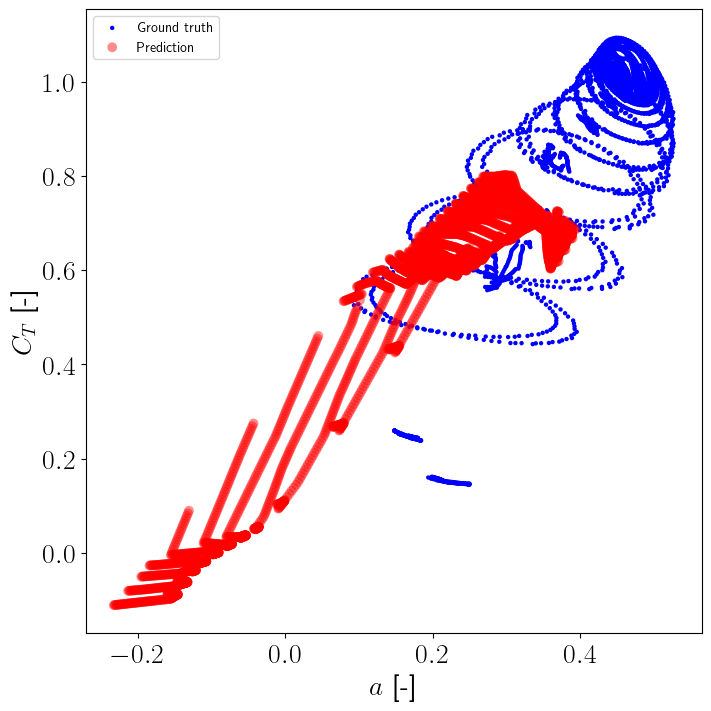

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,0], ct[:,:,0], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

#### divider


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Prepare the dataset with multiple (z1, z2) cases
def prepare_data(dataset_list):
    """Takes a list of (z1, z2, x_matrix, y_matrix) and prepares training data."""
    all_X_train = []
    all_Y_train = []
    all_X_val = []
    all_Y_val = []

    for z1, z2, x_matrix, y_matrix in dataset_list:
        r_flat = R.T.flatten()
        theta_flat = T.T.flatten()
        x_flat = x_matrix.flatten()
        y_flat = y_matrix.flatten()
        z1_flat = np.full_like(r_flat, z1)
        z2_flat = np.full_like(r_flat, z2)

        inputs = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat])
        outputs = np.column_stack([x_flat, y_flat])

        # Shuffle and split (80% train, 20% validation)
        indices = np.random.permutation(inputs.shape[0])
        split_idx = int(0.8 * inputs.shape[0])
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        all_X_train.append(inputs[train_idx])
        all_Y_train.append(outputs[train_idx])
        all_X_val.append(inputs[val_idx])
        all_Y_val.append(outputs[val_idx])

    # Stack into final training and validation sets
    X_train = np.vstack(all_X_train)
    Y_train = np.vstack(all_Y_train)
    X_val = np.vstack(all_X_val)
    Y_val = np.vstack(all_Y_val)

    return X_train, Y_train, X_val, Y_val

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output x, y
        )

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    """Train the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, Y_val_batch in val_loader:
                val_predictions = model(X_val_batch)
                val_loss += criterion(val_predictions, Y_val_batch).item()

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# 4. Prepare dataset and train the model
# Example dataset list: [(z1_1, z2_1, x_matrix_1, y_matrix_1), (z1_2, z2_2, x_matrix_2, y_matrix_2), ...]
dataset_list = [
    (4, 0,   ind[:,:,0],  ct[:,:,0]),
    (2, -2,  ind[:,:,1],  ct[:,:,1]),
    (2, 0,   ind[:,:,2],  ct[:,:,2]),
    (2, 2,   ind[:,:,3],  ct[:,:,3]),
    (0, -4,  ind[:,:,4],  ct[:,:,4]),
    (0, -2,  ind[:,:,5],  ct[:,:,5]),
    (0, 0,   ind[:,:,6],  ct[:,:,6]),
    (0, 2,   ind[:,:,7],  ct[:,:,7]),
    (0, 4,   ind[:,:,8],  ct[:,:,8]),
    (-2, -2, ind[:,:,9],  ct[:,:,9]),
    (-2, 0,  ind[:,:,10], ct[:,:,10]),
    (-2, 2,  ind[:,:,11], ct[:,:,11]),
    (-4, 0,  ind[:,:,12], ct[:,:,12]),
]

X_train, Y_train, X_val, Y_val = prepare_data(dataset_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = XY_Predictor()

# Train the model
train_model(model, train_loader, val_loader, epochs=100)

# 5. Evaluation function
def evaluate_model(model, r, theta, z1_eval, z2_eval, x_true, y_true):
    """Evaluate the model on a specific (z1, z2) case."""
    # Prepare input
    X_eval = np.column_stack([r.flatten(), theta.flatten(),
                              np.full_like(r.flatten(), z1_eval),
                              np.full_like(r.flatten(), z2_eval)])
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    # Reshape predictions
    x_pred = predictions[:, 0].reshape(r.shape)
    y_pred = predictions[:, 1].reshape(r.shape)

    return x_pred, y_pred

# Example evaluation
z1_eval, z2_eval = 4, 0  # Choose a test case
x_true = ind[:,:,0]
y_true = ct[:,:,0]  # Retrieve true x, y
x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)


Epoch 1/100, Train Loss: 0.024943, Val Loss: 0.006704
Epoch 2/100, Train Loss: 0.004245, Val Loss: 0.002848
Epoch 3/100, Train Loss: 0.002622, Val Loss: 0.002438
Epoch 4/100, Train Loss: 0.002244, Val Loss: 0.002457
Epoch 5/100, Train Loss: 0.002172, Val Loss: 0.001880
Epoch 6/100, Train Loss: 0.002022, Val Loss: 0.001887
Epoch 7/100, Train Loss: 0.001886, Val Loss: 0.001929
Epoch 8/100, Train Loss: 0.001744, Val Loss: 0.001410
Epoch 9/100, Train Loss: 0.001517, Val Loss: 0.001344
Epoch 10/100, Train Loss: 0.001282, Val Loss: 0.001594
Epoch 11/100, Train Loss: 0.001026, Val Loss: 0.000896
Epoch 12/100, Train Loss: 0.000843, Val Loss: 0.000608
Epoch 13/100, Train Loss: 0.000653, Val Loss: 0.000521
Epoch 14/100, Train Loss: 0.000565, Val Loss: 0.000560
Epoch 15/100, Train Loss: 0.000524, Val Loss: 0.000502
Epoch 16/100, Train Loss: 0.000504, Val Loss: 0.000434
Epoch 17/100, Train Loss: 0.000469, Val Loss: 0.000365
Epoch 18/100, Train Loss: 0.000415, Val Loss: 0.000370
Epoch 19/100, Train

In [ ]:
# Example evaluation
z1_eval, z2_eval = 0, 0  # Choose a test case
x_true = ind[:,:,6]
y_true = ct[:,:,6]  # Retrieve true x, y
x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)

/tmp/ipykernel_364145/1302491384.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_364145/1302491384.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

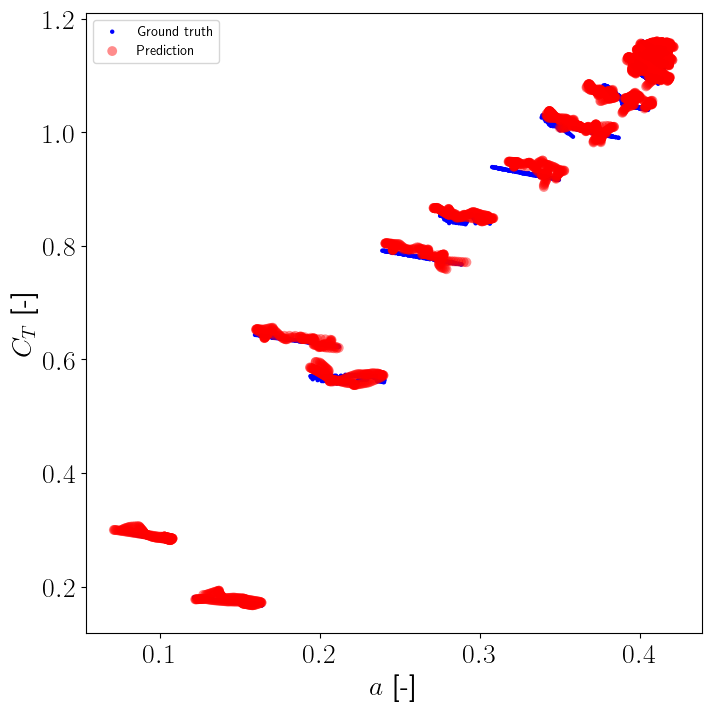

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

/tmp/ipykernel_364145/480405984.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_364145/480405984.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')
/tmp/ipykernel_364145/480405984.py:92: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_364145/480405984.py:93: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='

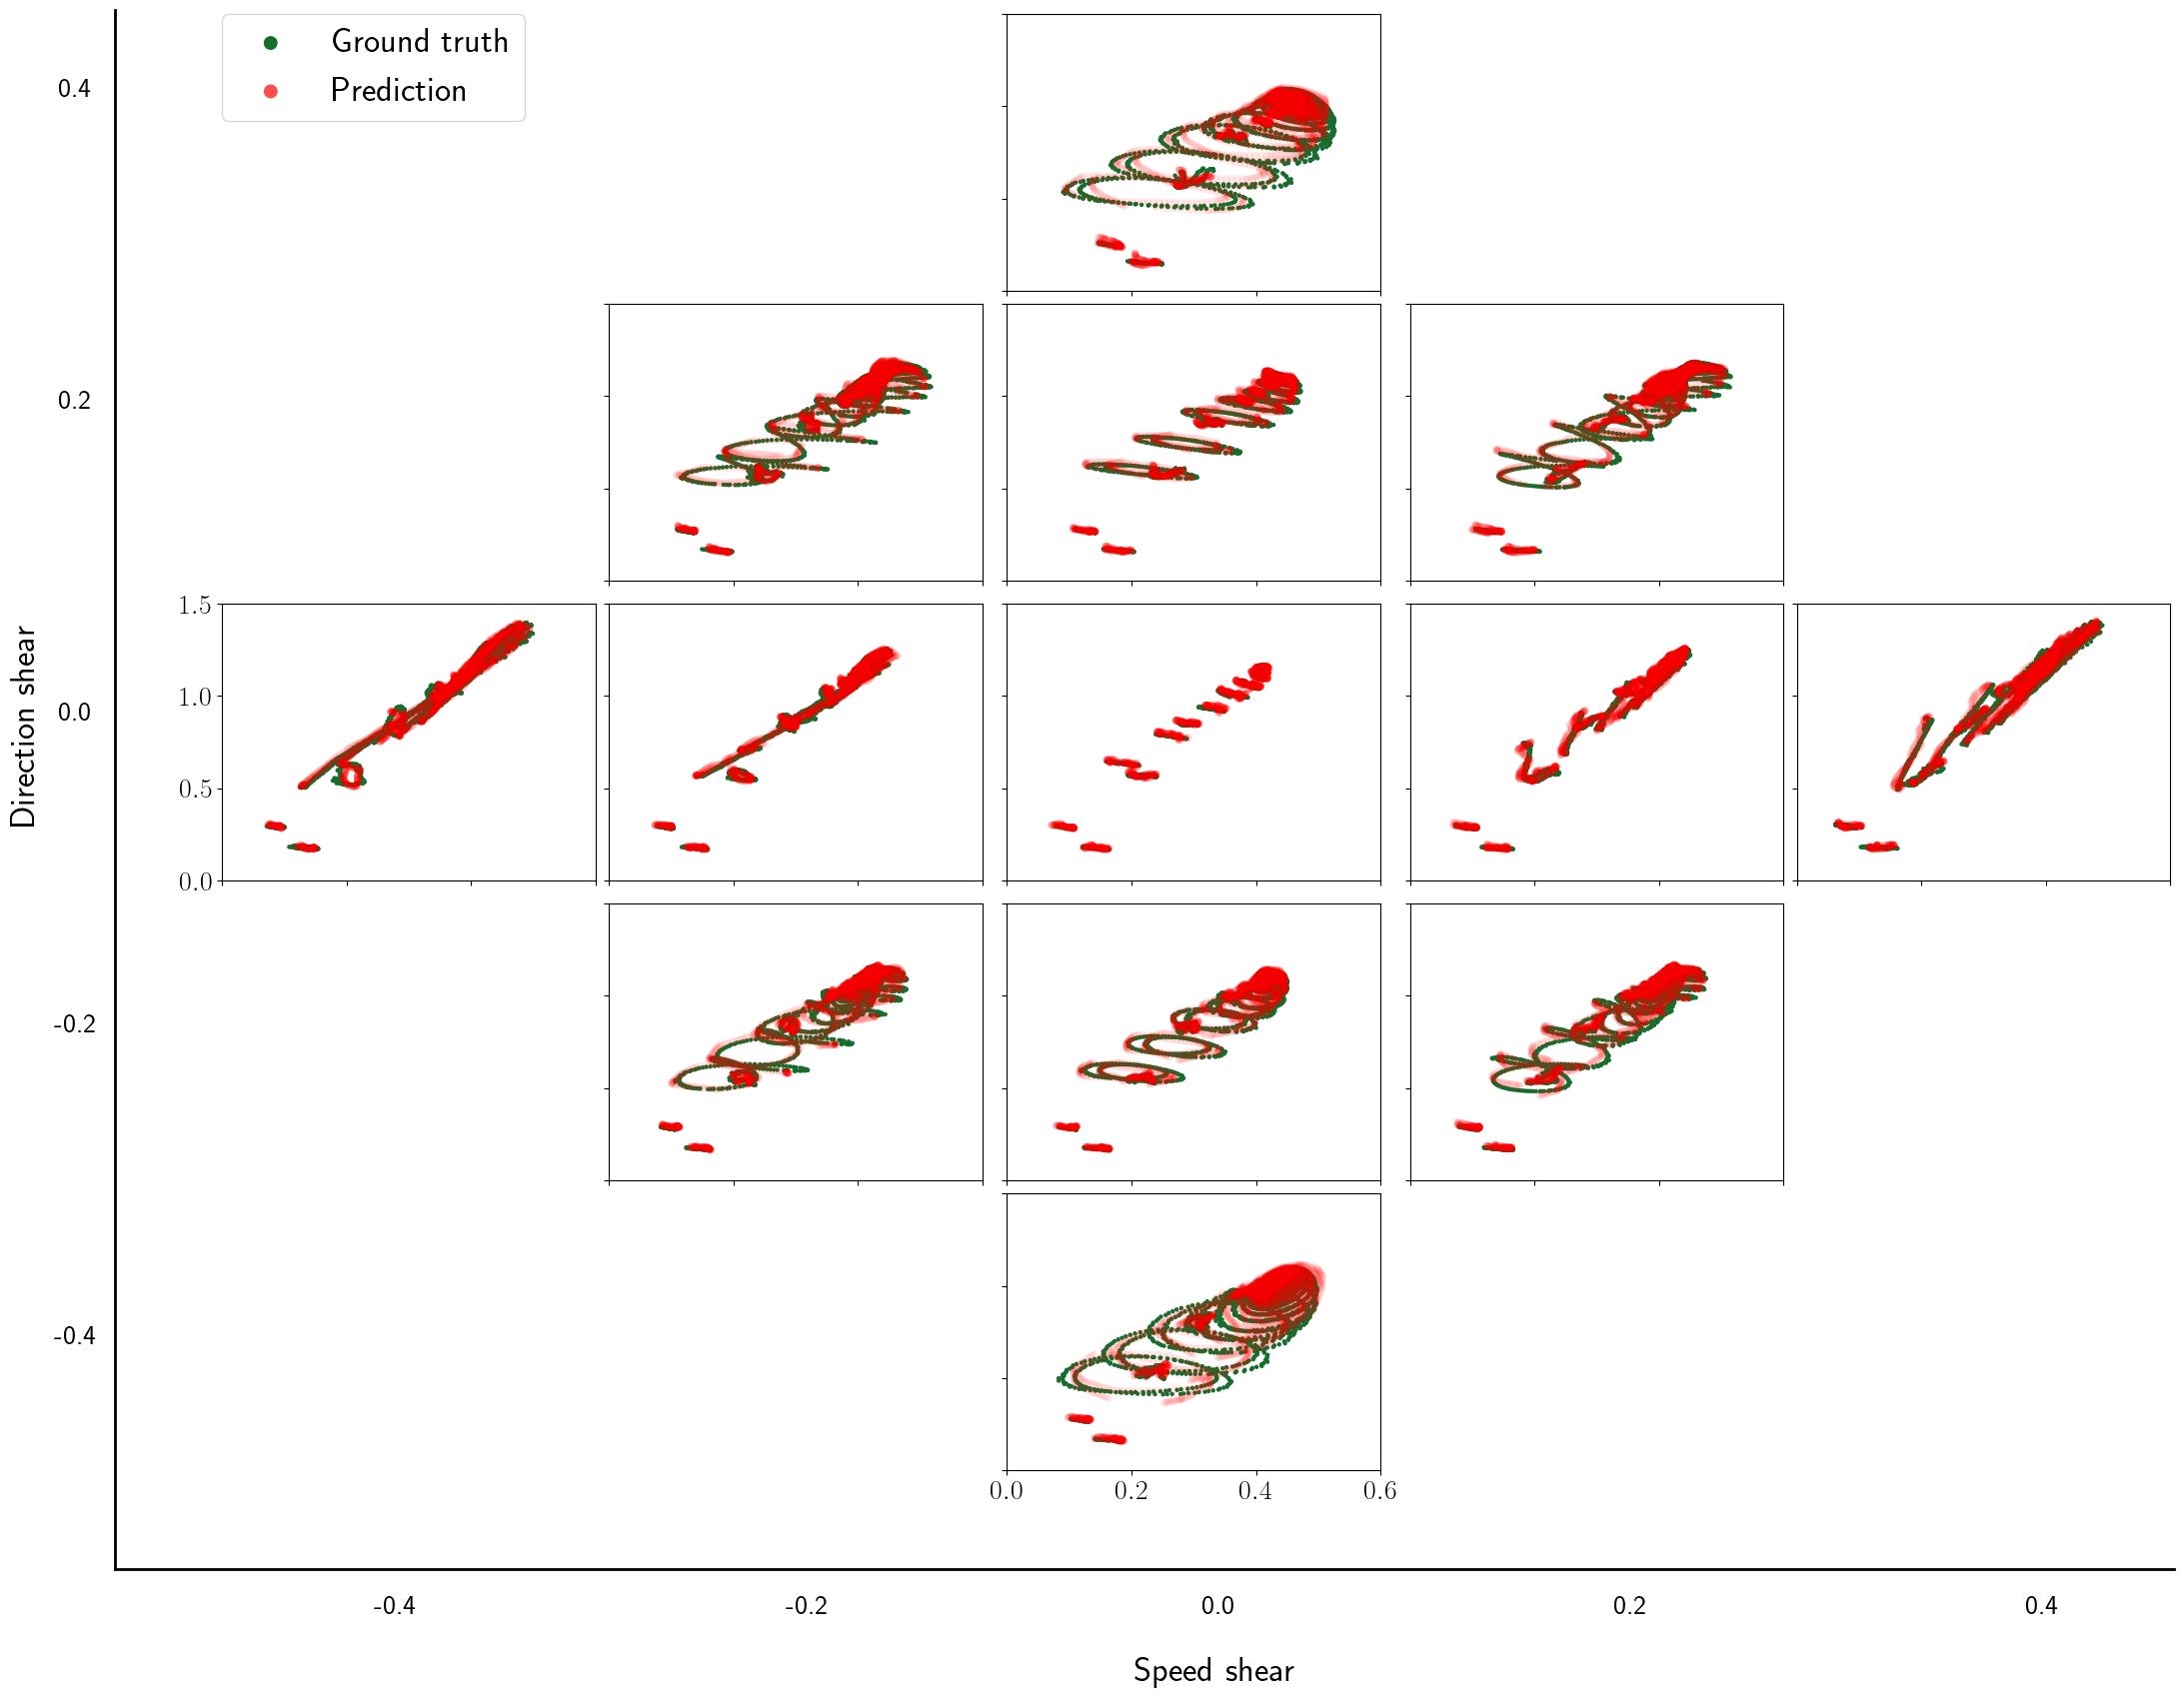

In [ ]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

v_ref = [4, 2, 2, 2, 0, 0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2, 0, 2, 0]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count,case in enumerate(casenames):

    x_true = ind[:,:,count]
    y_true = ct[:,:,count]  # Retrieve true x, y
    x_pred, y_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], x_true, y_true)

    ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
    ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    # ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')
# for spine in ax[4,4].spines.values():
#     spine.set_linewidth(2.5)
#     spine.set_edgecolor('red')

# ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
# ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
# ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

# ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
# ax[4,2].set_xlabel('$a$ [-]', fontsize=20)
# Add a single colorbar on the right-hand side
# cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
# cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)


# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='Prediction')
ax[0,0].legend(loc='upper left',borderaxespad=0, fontsize=25)

# plt.figure(dpi=700)
plt.savefig(f"/scratch/09909/smata/wrf_les_sweep/wrf_NN_.png", bbox_inches="tight", dpi=600)
plt.show()

## DIVIDER

In [ ]:
width = 0.75
alpha = 1.0


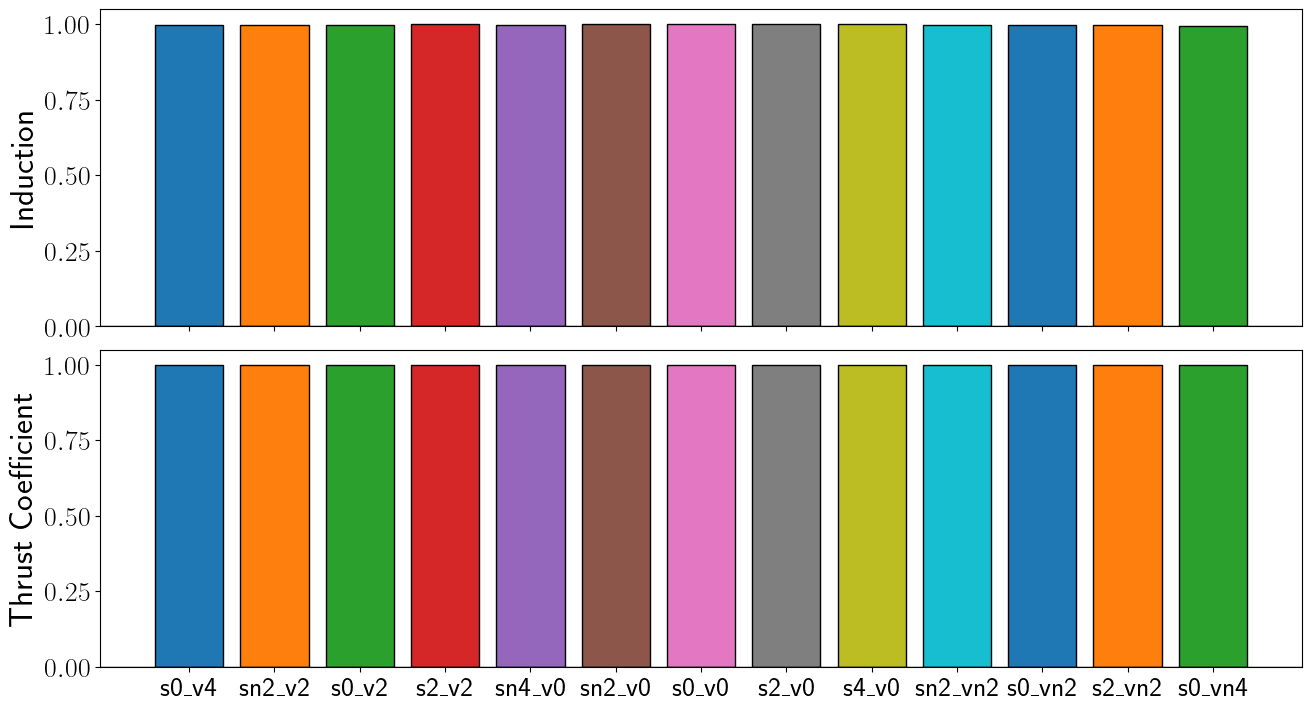

In [ ]:
inds = np.arange(len(casenames))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)

for count in range(len(casenames)):

    x_true = ind[:,:,count].flatten()
    y_true = ct[:,:,count].flatten()  # Retrieve true x, y
    x_pred, y_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], x_true, y_true)

    corr_x, _ = pearsonr(x_true, x_pred.flatten())
    corr_y, _ = pearsonr(y_true, y_pred.flatten())

    # print(corr_x)
    # print(corr_y)

    # induction
    ax[0].bar(inds[count], corr_x, edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'Induction', fontsize=fontsize)
    # ax[0].text(inds[count], 21, f'{corr_x:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    # ax[0].set_ylim([-7.2,25])

    # thrust
    ax[1].bar(inds[count],corr_y, edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'Thrust Coefficient', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    # ax[1].text(inds[count], -8, f'{corr_y:0.2f}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-8.5,2.3])

    ax[1].set_xticks(inds)
    ax[1].set_xticklabels(casenames)

# plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/figs/mit_freestream_no_ind_diffs.png", bbox_inches="tight", dpi=800)
plt.show()

In [ ]:
ind_rotor

np.float64(nan)